In [1]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB

# Load in the data

In [2]:
train_df = pd.read_csv("../data/train.2024.04.16.csv")
test_df = pd.read_csv("../data/test.2024.04.16.csv")

# Selected Features
- F01: ML - MC
- F07: Phi,S
- F09: log10 [ P(4-6 Hz) / S(4-6 Hz) ]
- F10: log10 [ P(6-8 Hz) / S(6-8 Hz) ]
- F13: log10 [ S(2-4 Hz) / S(8-10 Hz) ]

In [3]:
 # Five selected features
feature_col_names = ['F01', 'F07', 'F09', 'F10', 'F13']

In [4]:
train_all_feats_df = train_df[~np.any(np.isnan(train_df[feature_col_names]), axis=1)]
test_feats_df = test_df[~np.any(np.isnan(test_df[feature_col_names]), axis=1)]

In [5]:
# Get all training examples that have values for the selected features

X_train = train_all_feats_df[feature_col_names].to_numpy()
y_train = train_all_feats_df["y"].to_numpy()

In [6]:
# Get all testing examples that have values for the selected features
X_test = test_feats_df[feature_col_names].to_numpy()
y_test = test_feats_df["y"].to_numpy()

In [7]:
# Get all testing examples that have values for all 13 features
feature_col_all = ['F01', 'F02', 'F03', 'F04',
       'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'F13']
test_all_feats_df = test_df[~np.any(np.isnan(test_df[feature_col_all]), axis=1)]
X_test_all = test_all_feats_df[feature_col_names].to_numpy()
y_test_all = test_all_feats_df["y"].to_numpy()

In [8]:
"""Drop examples where any feature is < lb or > ub
"""
def drop_inds(X, y, lb, ub):
    drop_inds = np.unique(np.concatenate([np.unique(np.where(X < lb)[0]), 
                                        np.unique(np.where(X > ub)[0])]))
    print(drop_inds)
    keep_inds = np.sort(np.delete(np.arange(0, X.shape[0]), drop_inds))
    X = X[keep_inds, :]
    y = y[keep_inds]

    return X, y, keep_inds

In [9]:
# Remove examples with values beyond the outer fence of the training features
print(X_train.shape, X_test.shape, X_test_all.shape)
q1, q3  = np.percentile(X_train, [25, 75], axis=0)
IQR = q3 - q1
lower_fence = q1 - IQR*3.0
upper_fence = q3 + IQR*3.0
X_train, y_train, keep_inds1 = drop_inds(X_train, y_train, lower_fence, upper_fence)
X_test, y_test, keep_inds2 = drop_inds(X_test, y_test, lower_fence, upper_fence)
X_test_all, y_test_all, keep_inds3 = drop_inds(X_test_all, y_test_all, lower_fence, upper_fence)
print(X_train.shape, X_test.shape, X_test_all.shape)

(1358, 5) (326, 5) (207, 5)
[159 792 877 917]
[105]
[63]
(1354, 5) (325, 5) (206, 5)


In [10]:
print('Training:', X_train.shape, y_train.shape)
print('Testing:', X_test.shape, y_test.shape)
print('Training class percentage:', np.unique(y_train, return_counts=True)[1]/len(y_train))
print('Testing class percentage:', np.unique(y_test, return_counts=True)[1]/len(y_test))
print('Testing all feats class percentage:', np.unique(y_test_all, return_counts=True)[1]/len(y_test_all))

Training: (1354, 5) (1354,)
Testing: (325, 5) (325,)
Training class percentage: [0.16986706 0.71861152 0.11152142]
Testing class percentage: [0.16307692 0.72       0.11692308]
Testing all feats class percentage: [0.16990291 0.69417476 0.13592233]


In [11]:
# Scale features
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_all_scaled = scaler.transform(X_test_all)

# LDA

In [12]:
# Train the model
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)
y_train_pred_lda = lda.predict(X_train_scaled)

## LDA Training Results

In [13]:
cm = confusion_matrix(y_train, y_train_pred_lda)
print(cm)

[[195  13  22]
 [  7 966   0]
 [ 10   0 141]]


In [14]:
f1_score(y_train, y_train_pred_lda, average='macro')

0.9233987371705495

## LDA Testing Results with 5 features

In [15]:
X_test_scaled.shape

(325, 5)

In [16]:
45 + 3 + 5 + 1 + 233 + 2 + 34

323

In [17]:
y_test_pred_lda = lda.predict(X_test_scaled)

In [18]:
cm = confusion_matrix(y_test, y_test_pred_lda)
print(cm)

[[ 45   3   5]
 [  1 233   0]
 [  2   0  36]]


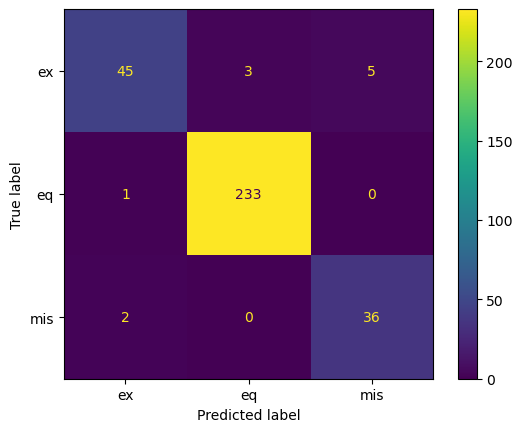

In [19]:
display = ConfusionMatrixDisplay(confusion_matrix=cm, 
                       display_labels=['ex', 'eq', 'mis'])
display.plot()

In [20]:
f1_score(y_test, y_test_pred_lda, average='macro')

0.9313236252254367

In [21]:
lda_test_misclassified = test_feats_df.iloc[keep_inds2][y_test != y_test_pred_lda]
lda_test_misclassified["prediction"] = y_test_pred_lda[y_test != y_test_pred_lda]
lda_test_misclassified.to_csv("ldaTestMisclassified.csv", index=False)
lda_test_misclassified

,Unnamed: 0,Date,Time,Elat,Elon,Dep,Tag,F01,F02,F03,...,F06,F07,F08,F09,F10,F11,F12,F13,y,prediction
365,1889,2016-05-05,22:23:14.54,40.623,-109.507,-2.0,ex,-0.12,-0.37,-0.47,...,15.24,14.64,0.13,0.14,0.14,0.10,0.14,0.16,0,1
405,8588,2022-06-16,01:18:58.58,39.435,-110.314,-1.5,mis,-0.40,-0.03,-0.07,...,13.61,13.33,0.08,0.15,0.24,0.28,0.20,0.52,2,0
489,9005,2022-08-23,05:28:26.37,39.429,-110.298,-1.6,mis,-0.38,0.02,0.09,...,13.53,12.97,0.07,0.14,0.20,0.24,0.18,0.40,2,0
527,836,2014-03-23,06:03:51.77,40.562,-111.263,13.3,eq,-0.17,0.89,0.57,...,13.82,13.75,NaN,0.08,0.08,0.09,NaN,0.07,1,0
532,1399,2015-04-20,22:28:25.77,40.566,-109.483,-2.0,ex,-0.02,-0.16,-0.21,...,13.82,13.98,0.02,0.05,-0.09,NaN,0.30,0.33,0,1
1198,1398,2015-04-20,22:28:25.73,40.550,-109.500,-2.0,ex,-0.30,-0.61,-0.39,...,14.69,13.74,0.01,0.04,-0.10,NaN,0.32,0.30,0,2
1241,2843,2018-05-02,20:52:25.73,40.505,-112.148,-2.0,ex,-0.08,0.09,0.30,...,13.66,12.44,0.14,0.20,0.10,-0.02,0.39,0.63,0,2
1287,127,2012-11-27,22:49:44.20,40.637,-109.499,-2.0,ex,-0.28,-0.21,-0.33,...,15.10,13.79,-0.09,-0.04,-0.07,0.02,0.50,0.48,0,2
1392,83,2012-10-26,22:34:02.60,40.525,-112.147,-2.0,ex,0.02,0.36,0.76,...,13.20,11.79,0.24,0.23,0.13,0.30,0.13,0.35,0,2
1504,229,2013-02-13,23:07:50.47,40.671,-109.481,-2.0,ex,-0.33,-0.37,-0.41,...,14.24,14.66,-0.12,-0.11,-0.11,-0.07,0.65,0.55,0,2


# LDA testing results with 13 features

F1-score when training with all 13 features: 0.91  
F1-score when training with Keith's 5 features: 0.93

In [22]:
y_test_all_pred_lda = lda.predict(X_test_all_scaled)
cm = confusion_matrix(y_test_all, y_test_all_pred_lda)
print(cm)

[[ 29   2   4]
 [  0 143   0]
 [  2   0  26]]


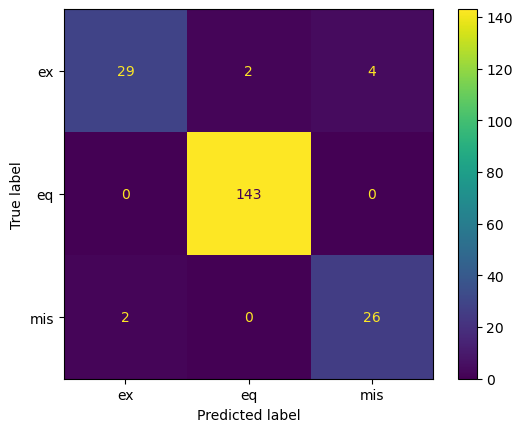

In [23]:
display = ConfusionMatrixDisplay(confusion_matrix=cm, 
                       display_labels=['ex', 'eq', 'mis'])
display.plot()

In [24]:
f1_score(y_test_all, y_test_all_pred_lda, average='macro')

0.9227983861604551

# Naive Bayes

## NB Training Results

In [25]:
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
y_train_pred_nb = nb.predict(X_train_scaled)

In [26]:
cm = confusion_matrix(y_train, y_train_pred_nb)
print(cm)

[[207   8  15]
 [ 25 948   0]
 [  7   1 143]]


In [27]:
f1_score(y_train, y_train_pred_nb, average='macro')

0.9302263246062035

## NB testing results with 5 features

In [28]:
y_test_pred_nb = nb.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_test_pred_nb)
print(cm)

[[ 50   1   2]
 [  3 231   0]
 [  2   0  36]]


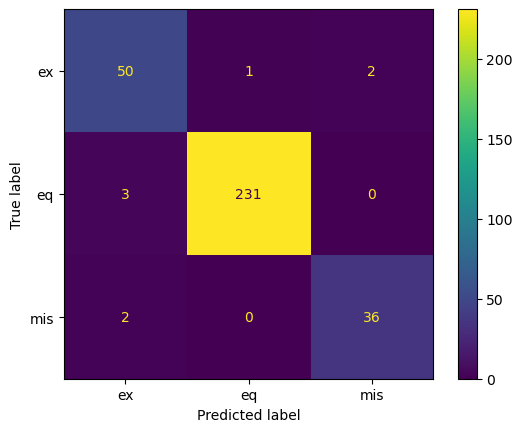

In [29]:
display = ConfusionMatrixDisplay(confusion_matrix=cm, 
                       display_labels=['ex', 'eq', 'mis'])
display.plot()

In [30]:
f1_score(y_test, y_test_pred_nb, average='macro')

0.9549035519971443

In [31]:
nb_test_misclassified = test_feats_df.iloc[keep_inds2][y_test != y_test_pred_nb]

In [32]:
y_test_pred_nb[y_test != y_test_pred_nb]

array([0, 0, 0, 0, 2, 2, 0, 1])

In [33]:
nb_test_misclassified["predicted"] = y_test_pred_nb[y_test != y_test_pred_nb]
nb_test_misclassified
nb_test_misclassified.to_csv("nbTestMisclassified.csv", index=False)

## NB testing results w/ 13 features

F1-score when training with all 13 features: 0.93  
F1-score when training with Keith's 5 features features: 0.94

In [34]:
y_test_all_pred_nb = nb.predict(X_test_all_scaled)
cm = confusion_matrix(y_test_all, y_test_all_pred_nb)
print(cm)

[[ 32   1   2]
 [  0 143   0]
 [  1   0  27]]


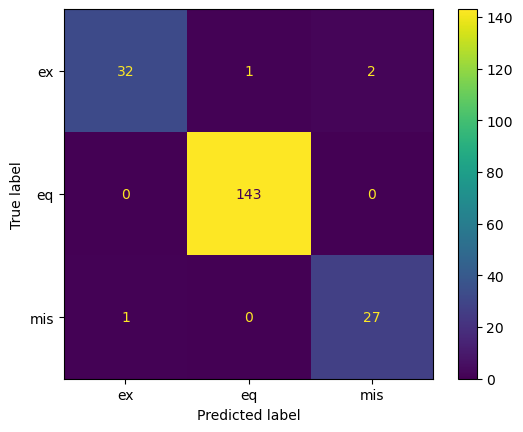

In [35]:
display = ConfusionMatrixDisplay(confusion_matrix=cm, 
                       display_labels=['ex', 'eq', 'mis'])
display.plot()

In [36]:
f1_score(y_test_all, y_test_all_pred_nb, average='macro')

0.9616868570277918

In [37]:
test_all_feats_df.iloc[keep_inds3][y_test_all != y_test_all_pred_nb]

,Unnamed: 0,Date,Time,Elat,Elon,Dep,Tag,F01,F02,F03,...,F05,F06,F07,F08,F09,F10,F11,F12,F13,y
129,8396,2022-03-11,12:56:17.67,39.421,-110.306,-2.2,mis,-0.45,0.04,-0.06,...,-135.9,12.72,12.38,-0.02,0.01,0.03,-0.03,0.09,0.21,2
656,2062,2016-09-11,20:52:48.00,40.509,-112.169,-2.0,ex,-0.23,0.15,0.02,...,-127.0,13.67,12.74,0.15,0.19,0.31,0.24,0.38,0.53,0
1036,1359,2015-03-23,18:07:34.04,40.521,-112.154,-2.0,ex,-0.26,0.41,0.12,...,-136.6,12.89,12.64,0.10,0.04,0.17,0.34,0.41,0.53,0
1659,1651,2015-10-13,01:02:14.31,40.607,-109.531,-2.0,ex,-0.40,-0.35,-0.52,...,-103.0,14.17,14.53,0.02,-0.01,-0.04,0.04,0.16,0.23,0
